In [1]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [2]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
bins = SurveyFieldBins(ra=ztf_fields[:,1], dec=ztf_fields[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 7 degrees for now
# There is more field overlap the closer you get to the poles (no surprise)

In [34]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
import astrobject.simulation as simul
obs_days = np.arange(58000, 58181, 1)

dec_range = [-20, 60]
ra_range = [0, 90]
ra_shift = 360. / 365.25

t_obs = 60.
t_night = 8. * 3600

obs = {'time': [], 'field': [], 'band': [], 'skynoise': []}
for d in obs_days:
    # Find fields that have their center within dec_range and in ra_range shifted by ra_shift for each day
    field_idx = np.where((bins.ra > ra_range[0] + ra_shift * (d - obs_days[0])) &
                         (bins.ra < ra_range[1] + ra_shift * (d - obs_days[0])) &
                         (bins.dec > dec_range[0]) & (bins.dec < dec_range[1]))[0]
    
    # Sort first by ra then by dec
    field_idx = field_idx[np.argsort(bins.ra[field_idx])]
    field_idx = field_idx[np.argsort(bins.dec[field_idx])]

    for k, t in enumerate(np.arange(0, t_night, t_obs)):
        obs['time'].append(d + t / 86400.)
        obs['field'].append(field_idx[k % len(field_idx)])
        obs['band'].append('desr')
        obs['skynoise'].append(1.) # TBD later, completely random number for now
        
plan = simul.SurveyPlan(time=obs['time'], band=obs['band'], obs_field=obs['field'],
                        skynoise=obs['skynoise'],
                        fields=dict(ra=ztf_fields[:,1], dec=ztf_fields[:,2]))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f43909b4610>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f43905560d0>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f43905b6890>,
 'figure': <matplotlib.figure.Figure at 0x7f43909b40d0>}

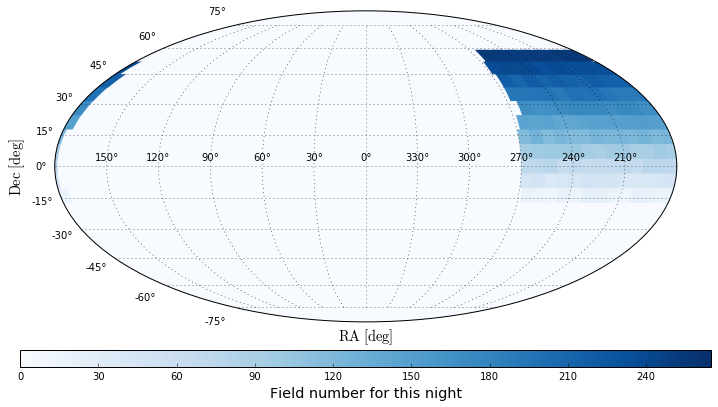

In [7]:
# Example of selected fields (last of the nights in the mock survey)
# The fields are number by the order in which they are observed.
vals = np.zeros(bins.nbins)
for k,l in enumerate(field_idx):
    vals[l] = k
    
bins.imshow(vals, cblabel="Field number for this night")

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f43909b4990>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f43904d4890>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f4390a89c10>,
 'figure': <matplotlib.figure.Figure at 0x7f4390a96f10>}

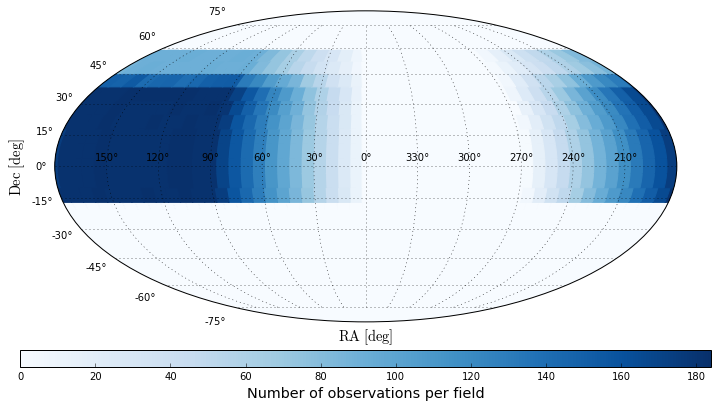

In [9]:
# Number of pointings per field
vals, _ = np.histogram(obs['field'], bins=range(bins.nbins + 1))
bins.imshow(vals, cblabel="Number of observations per field")

In [10]:
tr = simul.sn_generator([0.01,0.1], ratekind="basic", 
                        mjd_range=[obs_days[0] - 60, obs_days[-1] + 25])
# ratekind is the rate of the transient: basiclow = 1e3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.
# type_ is the type of transient. 
# This will parse the ratekind+type_ do get the good rate function

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f4390ed9cd0>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f4390870290>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f4390922110>,
 'figure': <matplotlib.figure.Figure at 0x7f4391388290>}

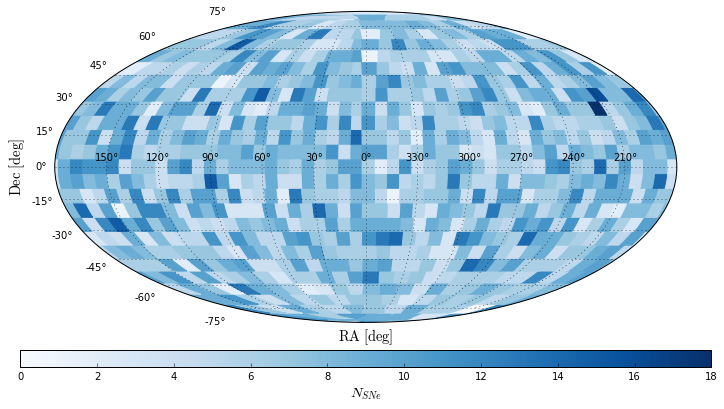

In [11]:
tr.hist_skycoverage(bins=bins)
# Since the fields can overlap, some SNe will be counted twice
# Overlapping fields partly obscure previously drawn 
# Some distortions when drawing fields near the poles (to be fixed later)

In [35]:
instprop = {"desg":{"gain":1,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1,"zp":30,"zpsys":'ab'}}

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

In [36]:
lcs = survey.get_lightcurves()

In [37]:
lcs[:10]

[None, None, None, None, <Table masked=False length=366>
      time       band        flux         fluxerr      zp   zpsys  
    float64    string32    float64        float64    int64 string16
 ------------- -------- -------------- ------------- ----- --------
 58073.0520833     desr -183.530587641  13.825741866    30       ab
 58073.2354167     desr -214.740982507 13.7967066303    30       ab
      58074.05     desr -154.016551544 13.6668396865    30       ab
 58074.2340278     desr -188.036668596 13.6375642832    30       ab
   58075.04375     desr -166.665183747 13.5096313673    30       ab
 58075.2256944     desr -182.631367361 13.4812799997    30       ab
 58076.0472222     desr -177.536009336 13.3542564341    30       ab
   58076.05625     desr -171.605114241 13.3528429335    30       ab
 58076.2319444     desr -187.876123344 13.3252021601    30       ab
 58076.2409722     desr  -184.60525648 13.3237750915    30       ab
           ...      ...            ...           ...   ... 

In [38]:
lc = lcs[4]
model = sncosmo.Model(source=survey.generator.lightcurve_model)
model.set(z=lc.meta['z'])
res, fitted_model = sncosmo.fit_lc(lc, model,
                                   ['t0', 'x0', 'x1', 'c'])

sncosmo.plot_lc(data, model=fitted_model, errors=res.errors)

DataQualityError: No data points with S/N > 5.0. Initial guessing failed.

In [26]:
import sncosmo
model = sncosmo.Model(source=)
p = {"z":survey.generator.zcmb[4],
     "c":survey.generator.color[4],
     "x1":survey.generator.x1[4],
     "x0":survey.generator.lightcurve["x0"][4],
     "t0":survey.generator.mjd[4]}
obs = survey.observations[4]

In [27]:
lcs = sncosmo.realize_lcs(obs, model, [p])
print lcs[0]

     time     band      flux         fluxerr     zp zpsys
------------- ---- -------------- ------------- --- -----
58073.0520833 desr -210.127479984 150.632503591  30    ab
58073.2354167 desr -290.137235382 150.629841379  30    ab
     58074.05 desr -215.884163181 150.618001935  30    ab
58074.2340278 desr -145.004807024 150.615348353  30    ab
  58075.04375 desr -138.738515059 150.603818476  30    ab
58075.2256944 desr -211.826464451 150.601277918  30    ab
58076.0472222 desr -184.304288612 150.589960372  30    ab
  58076.05625 desr -479.783156474  150.58983503  30    ab
58076.2319444 desr  173.556579947 150.587386632  30    ab
58076.2409722 desr -161.534617081  150.58726036  30    ab
          ...  ...            ...           ... ...   ...
58163.0576389 desr -258.491210274 150.184508591  30    ab
58163.2340278 desr  69.3930949414 150.184508591  30    ab
58163.2430556 desr  206.479840298 150.184508591  30    ab
58164.0569444 desr  72.6143192657 150.184508591  30    ab
58164.2381944 

In [9]:
observed = plan.observed_on(tr0.ra, tr0.dec, 
                            mjd_range=np.array([tr0.mjd - 20 * (1 + np.array(tr0.zcmb)), 
                                                tr0.mjd + 50 * (1 + np.array(tr0.zcmb))]))
n_obs = np.array([len(a) for a in observed])

SNe observed: 1509 out of 6063


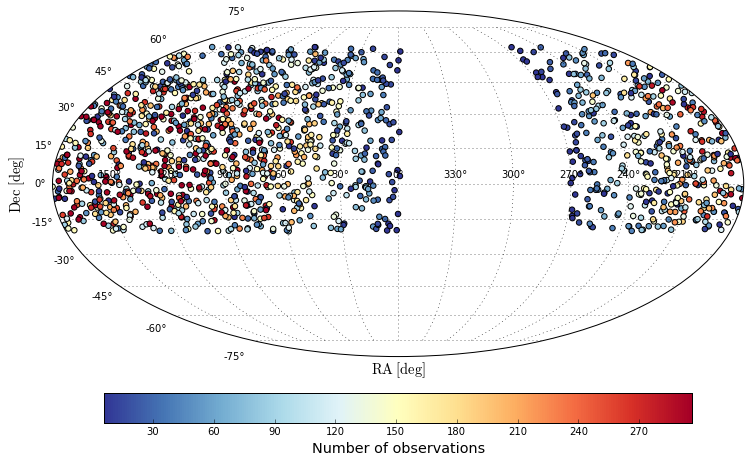

In [10]:
tr0.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=(n_obs > 0))
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), tr0.ntransient)